In [10]:
import pandas as pd
import numpy as np
import scipy as sp
from bs4 import BeautifulSoup    
import re
from sklearn.naive_bayes import MultinomialNB
from sklearn.cross_validation import train_test_split
from sklearn import metrics
from sklearn import cross_validation
from sklearn.preprocessing import LabelEncoder
from sklearn.learning_curve import learning_curve
from matplotlib import pyplot as plt
%matplotlib inline

In [11]:
# find null values for target column and remove from rows from tf
# outputs: target column, new tf matrix

def denull(tfidf, df, target_col):
    target = df[df[target_col].isnull()==False][target_col]
    tf_target = tfidf.ix[target.index]
    return (target, tf_target)

# Convert tf to sparse matrix
def sparse_df_to_array(tf_target):
    num_rows = tf_target.shape[0]   

    data = []
    row = []
    col = []

    for i, col_name in enumerate(tf_target.columns):
        if isinstance(tf_target[col_name], pd.SparseSeries):
            column_index = tf_target[col_name].sp_index
            if isinstance(column_index, BlockIndex):
                column_index = column_index.to_int_index()

            ix = column_index.indices
            data.append(tf_target[col_name].sp_values)
            row.append(ix)
            col.append(len(tf_target[col_name].sp_values) * [i])
        else:
            data.append(tf_target[col_name].values)
            row.append(np.array(range(0, num_rows)))
            col.append(np.array(num_rows * [i]))

    data_f = np.concatenate(data)
    row_f = np.concatenate(row)
    col_f = np.concatenate(col)

    arr = sp.sparse.coo_matrix((data_f, (row_f, col_f)), tf_target.shape, dtype=np.float64)
    return arr.tocsr()    

In [12]:
# encoder must be a function

def process(tfidf_matrix, df, target, encoder=lambda x:LabelEncoder().fit_transform(x)):
    # denull tf and df
    (target_col, target_tf) = denull(tf, okc, target)
    # encode values
    target_col = encoder(target_col)
    # Make tf sparse
    sparse_tf = sparse_df_to_array(target_tf)
    # Do not use train test split before learning curve
    return (sparse_tf, target_col)
    

In [16]:
# Process sex classifier
# must be run on one_long_essay.csv not profiles to avoid error.  WHY???

okc = pd.read_csv('../Assets/A/one_long_essay.csv')
tf = pd.read_csv('../Assets/A/Tfidf_Variations/Long_Essay/top_2000_words_nomax_stemmed.csv')

In [17]:
(X,y) = process(tf, okc, "sex")

In [18]:
X.shape

(57809, 2001)

<module 'matplotlib.pyplot' from '//anaconda/lib/python2.7/site-packages/matplotlib/pyplot.pyc'>

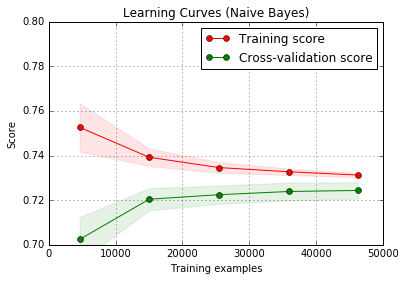

In [19]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    See http://scikit-learn.org/stable/auto_examples/model_selection/plot_learning_curve.html
    
    Generate a simple plot of the test and traning learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : integer, cross-validation generator, optional
        If an integer is passed, it is the number of folds (defaults to 3).
        Specific cross-validation objects can be passed, see
        sklearn.cross_validation module for the list of possible objects

    n_jobs : integer, optional
        Number of jobs to run in parallel (default 1).
    """
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt


title = "Learning Curves (Naive Bayes)"
# Cross validation with 100 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
cv = cross_validation.ShuffleSplit(X.shape[0], n_iter=100,
                                   test_size=0.2, random_state=0)

estimator = MultinomialNB()
plot_learning_curve(estimator, title, X, y, ylim=(0.7, 0.8), cv=cv, n_jobs=1)

There are concerns about doing analysis based on Dataset B.  Learning from the NB model improves rapidly up to the 15,000 data points.  Training a model on under 8,000 may produce a significantly weaker model.  Hopefully training neural networks will help us to regain some of the accuracy and precision that we lose by working with less data.